In [69]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [70]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [88]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [89]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [90]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [91]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement

In [92]:
# Create a session
Station = Base.classes.station


# Exploratory Precipitation Analysis

In [93]:
# Find the most recent date in the data set.
#create a session
session = Session(engine)
# Query to get the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date,

('2017-08-23',)

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

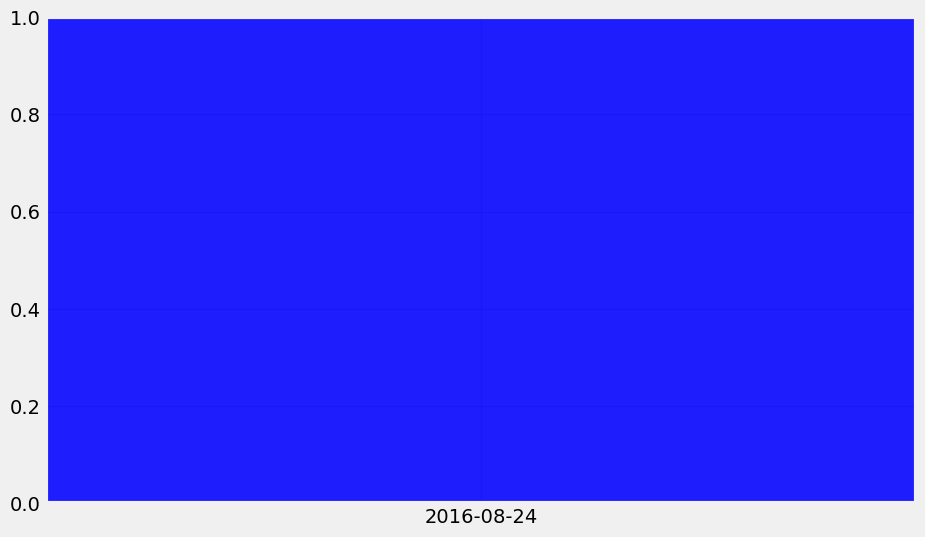

In [97]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Convert the most recent date to a datetime object
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date 12 months ago
one_year_ago = most_recent_date - timedelta(days=365)

# Query precipitation data for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .filter(Measurement.date <= most_recent_date)\
    .order_by(Measurement.date).all()

# Extract dates and precipitation values from the query results
dates = [result[0] for result in precipitation_data]
precipitation = [result[1] for result in precipitation_data]

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(dates, precipitation, width=3, color='b', alpha=0.5, align='center')
plt.title('Last 12 Months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Calculate the date one year from the last date in data set.

# Find the most recent date in the dataset
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()

# Convert the most recent date string to a datetime object
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')



# Calculate the date one year from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Convert the result back to a string representation if needed
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

print("Date one year ago:", one_year_ago_str)



# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).all()

# Print the results
for date, precipitation in results:
    print(f"Date: {date}, Precipitation: {precipitation}")


# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Print the DataFrame
print(df
# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data

In [ ]:
results = session.query(Measurement.date, Measurement.prcp).all()

# Print the results
for date, precipitation in results:
    print(f"Date: {date}, Precipitation: {precipitation}")
    df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Print the DataFrame
print(df)

Date: 2010-01-01, Precipitation: 2.0
Date: 2010-01-02, Precipitation: 0.0
Date: 2010-01-03, Precipitation: 0.0
Date: 2010-01-04, Precipitation: 0.0
Date: 2010-01-06, Precipitation: None
Date: 2010-01-07, Precipitation: 1.5
Date: 2010-01-08, Precipitation: 0.0
Date: 2010-01-09, Precipitation: 0.0
Date: 2010-01-10, Precipitation: 0.0
Date: 2010-01-11, Precipitation: 0.3
Date: 2010-01-12, Precipitation: 0.0
Date: 2010-01-14, Precipitation: 0.0
Date: 2010-01-15, Precipitation: 0.0
Date: 2010-01-16, Precipitation: 0.0
Date: 2010-01-17, Precipitation: 0.0
Date: 2010-01-18, Precipitation: 0.0
Date: 2010-01-19, Precipitation: 0.0
Date: 2010-01-20, Precipitation: 0.0
Date: 2010-01-21, Precipitation: 0.0
Date: 2010-01-22, Precipitation: 0.0
Date: 2010-01-23, Precipitation: 0.0
Date: 2010-01-24, Precipitation: 0.3
Date: 2010-01-25, Precipitation: 0.0
Date: 2010-01-26, Precipitation: 1.0
Date: 2010-01-27, Precipitation: 3.0
Date: 2010-01-28, Precipitation: 0.0
Date: 2010-01-30, Precipitation: None

In [127]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Print the DataFrame
df

,Date,Precipitation
0,2010-01-01,2.0
1,2010-01-02,0.0
2,2010-01-03,0.0
3,2010-01-04,0.0
4,2010-01-06,NaN
...,...,...
19545,2017-08-19,2.3
19546,2017-08-20,NaN
19547,2017-08-21,14.2
19548,2017-08-22,12.7


In [126]:
df_sorted = df.sort_values(by='Date')

# Print the sorted DataFrame
df_sorted

,Date,Temperature
0,2016-08-24,25.0
1,2016-08-25,26.7
2,2016-08-26,26.7
3,2016-08-27,23.9
4,2016-08-28,22.8
...,...,...
346,2017-08-14,25.0
347,2017-08-15,25.0
348,2017-08-16,24.4
349,2017-08-17,24.4


In [111]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()

summary_statistics

count    18103.000000
mean         4.083920
std         11.905419
min          0.000000
25%          0.000000
50%          0.300000
75%          2.800000
max        292.900000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [116]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()

[(total_stations,)]

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [120]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count().desc())\
    .first()[0]

# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
                            .filter(Measurement.station == most_active_station_id)\
                            .all()

# Extracting results and formatting as requested
temperature_stats_formatted = [(round(temperature_stats[0][0], 1),
                                round(temperature_stats[0][1], 1),
                                round(temperature_stats[0][2], 12))]

print(temperature_stats_formatted)

[(12.2, 29.4, 22.035822510823)]


In [125]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()
